# Polynomial Curve Fitting (from 1.1 but without using any packages)

Polynomial regression of synthetic data (sine wave + Gaussian noise).

Data obtained from http://research.microsoft.com/en-us/um/people/cmbishop/PRML/webdatasets/curvefitting.txt

In [1]:
import matplotlib.pyplot as plt
import numpy as np

## Load data

In [2]:
data = np.loadtxt('../data/curvefitting.txt', dtype=str, delimiter=' ')

In [3]:
data = data.astype(np.float64)

In [4]:
x = data[:, 0]
t = data[:, 1]

In [5]:
# generate test data
N_test = 100  # number of test points
sigma = 0.3
x_test = np.random.rand(N_test)
t_test = np.sin(2 * np.pi * x_test) + sigma * np.random.randn(N_test)

In [6]:
# for plotting the sinusoid
x_grid = np.linspace(0, 1, 100)
t_grid = np.sin(2 * np.pi * x_grid)

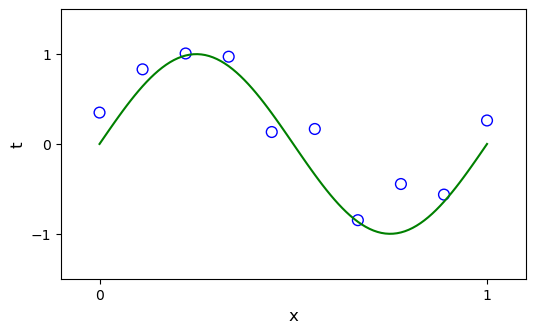

In [7]:
plt.figure(figsize=(6, 3.5))
plt.plot(x_grid, t_grid, 'g')  # ground truth sinusoid
plt.scatter(x, t, facecolors='none', edgecolors='b', s=60)
plt.xlim([-0.1, 1.1])
plt.ylim([-1.5, 1.5])
plt.xticks(ticks=[0, 1])
plt.yticks(ticks=[-1, 0, 1])
plt.xlabel('x', fontsize=12)
plt.ylabel('t', fontsize=12)
plt.show()

## Polynomial curve fitting

In [8]:
x.shape

(10,)

In [9]:
t.shape

(10,)

In [10]:
def create_design_matrix(x, deg):
    """create a design matrix for polynomial regression using broadcasting
    
    Args:
        x (np.array): observations (N, )
        deg (int): degree of polynomial
    
    Returns:
        Phi (np.array): design matrix in PRML (3.16), (N, M)
    """
    M = deg + 1  # M includes the bias term
    N = len(x)

    Phi = x[:, np.newaxis] ** np.arange(M)[np.newaxis, :]  # (N, 1) ** (1, M)
    
    return Phi

In [11]:
Phi = create_design_matrix(x, deg=9)

In [12]:
def solve_normal_equation(Phi, t, ln_lambda):
    """solve the normal equation for linear reqression (3.15)
    
    Args:
        Phi (np.array): design matrix (N, M)
        t (np.array): target values (N, )
        ln_lambda (float): natural log of the regularization parameter
    
    Returns:
        w_ML (np.array): coefficients including the bias term (M + 1, )
    """
    lambda_ = np.exp(ln_lambda)
    M = Phi.shape[1]
    A = lambda_ * np.eye(M) + Phi.T @ Phi
    B = Phi.T @ t
    w_ML = np.linalg.solve(A, B)  # faster and numerically more stable than np.linalg.inv
    
    return w_ML

In [13]:
def poly_fit(x, t, x_grid, deg, ln_lambda):
    """
    Args:
        x (np.array): inputs (N, )
        t (np.array): target values (N, )
        x_grid (np.array): input values for making predictions (N_grid, )
        deg (int): degree of the polynomial
        ln_lambda (float): natural log of theregularization paramter
        
    Returns:
        t_pred (np.array): predicted values for x_grid (N_grid, )
        w_ML (np.array): coefficients (M, 1)
    """
    Phi = create_design_matrix(x, deg)
    w_ML = solve_normal_equation(Phi, t, ln_lambda)
    
    Phi_2 = create_design_matrix(x_grid, deg)
    t_pred = Phi_2 @ w_ML
    
    return t_pred, w_ML

In [14]:
def plot_fit(x, t, x_grid, t_pred, ax, ln_lambda):
    ax.scatter(x, t, facecolors='none', edgecolors='b', s=60)
    ax.plot(x_grid, t_grid , 'g')
    ax.plot(x_grid, t_pred, 'r')
    ax.text(x=0.7, y=0.9, s=r'ln $\lambda$ = ' + f'{ln_lambda}', fontsize=14) 
    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([-1.4, 1.4])
    ax.set_xticks(ticks=[0, 1])
    ax.set_yticks(ticks=[-1, 0, 1])
    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('t', fontsize=12)

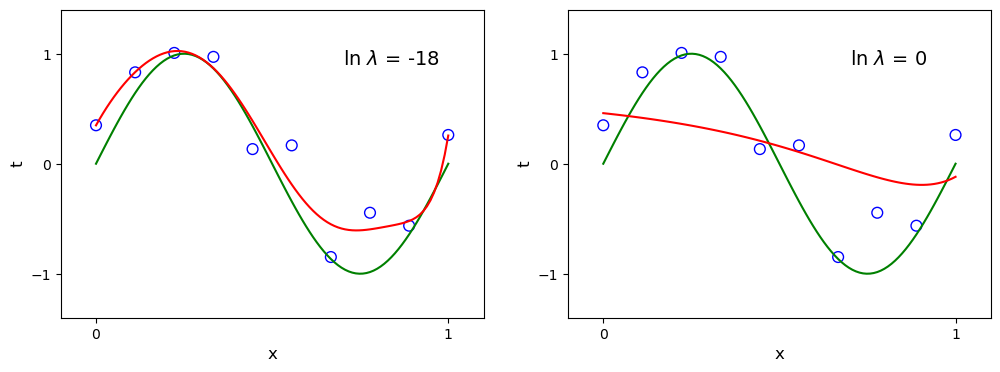

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
ln_lambda_list = [-18, 0]
for i, ln_lambda in enumerate(ln_lambda_list):
    t_pred, _ = poly_fit(x, t, x_grid, deg=9, ln_lambda=ln_lambda)
    plot_fit(x, t, x_grid, t_pred, axs[i], ln_lambda)

## Examine the coefficients (Table 1.1)

In [16]:
np.set_printoptions(precision=2)

In [17]:
def print_coefs(x, t, ln_lambda):
    """
    Args:
        x (np.array, float): inputs
        t (np.array, float): target values
        lambda_ (float): regulariztation parameter
        
    Returns:
        prints the coefficients
    """
    _, coef = poly_fit(x, t, x_grid, deg=9, ln_lambda=ln_lambda)
    print('\n'.join([f'w{i}:  {c:.2f}' for i, c in enumerate(coef)]))

In [18]:
print_coefs(x, t, ln_lambda=-np.inf)

w0:  0.35
w1:  232.46
w2:  -5324.05
w3:  48588.33
w4:  -231733.32
w5:  640298.23
w6:  -1062219.32
w7:  1042806.03
w8:  -557897.51
w9:  125249.06


In [19]:
print_coefs(x, t, ln_lambda=-18)

w0:  0.35
w1:  5.77
w2:  -14.97
w3:  29.86
w4:  -95.62
w5:  35.17
w6:  168.71
w7:  -18.04
w8:  -273.18
w9:  162.19


In [20]:
print_coefs(x, t, ln_lambda=0)

w0:  0.46
w1:  -0.34
w2:  -0.37
w3:  -0.24
w4:  -0.12
w5:  -0.02
w6:  0.05
w7:  0.11
w8:  0.16
w9:  0.20


# RMS as a function of $\lambda$

In [21]:
def RMS(t_pred, t):
    return np.sqrt(np.mean(((t_pred - t) ** 2)))

In [22]:
def poly_fit_RMS(x, t, x_test, t_test, deg, ln_lambda):
    """
    Args:
        x (np.array): inputs (N, )
        t (np.array): target values (N, )
        x_test (np.array): input values for making predictions (N_test, )
        deg (int): degree of the polynomial
        ln_lambda (float): natural log of theregularization paramter
        
    Returns:
        t_pred (np.array): predicted values for x_grid (N_grid, )
        w_ML (np.array): coefficients (M, 1)
    """
    t_pred, _ = poly_fit(x, t, x, deg, ln_lambda)
    RMS_train = RMS(t_pred, t)
    
    t_pred, _ = poly_fit(x, t, x_test, deg, ln_lambda)
    RMS_test = RMS(t_pred, t_test)
    
    return RMS_train, RMS_test

In [23]:
ln_lambda_list = np.linspace(-40, 5, 50)

RMS_train_list = []
RMS_test_list = []

for ln_lambda in ln_lambda_list:
    RMS_train, RMS_test = poly_fit_RMS(x, t, x_test, t_test, deg=9, ln_lambda=ln_lambda)
    RMS_train_list.append(RMS_train)
    RMS_test_list.append(RMS_test)

E_train = np.array(RMS_train_list)
E_test = np.array(RMS_test_list)

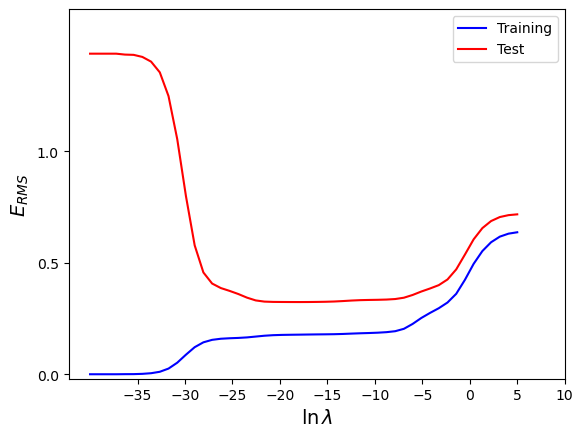

In [24]:
plt.plot(ln_lambda_list, E_train, 'b-', markerfacecolor='none', ms=10, label='Training')
plt.plot(ln_lambda_list, E_test, 'r-', markerfacecolor='none', ms=10, label='Test')
plt.ylim(-0.02, E_test.max() + 0.2)
plt.legend()
plt.xticks(ticks=np.arange(-35, 15, 5))
plt.yticks(ticks=[0, 0.5, 1])
plt.xlabel(r'$\ln \lambda$', fontsize=14)
plt.ylabel(r'$E_{RMS}$', fontsize=14)
plt.show()